In [1]:
import numpy as np 
from scipy.integrate import quad 
import os
import matplotlib.pyplot as plt
import sympy as smp
from mpl_toolkits import mplot3d
from pathos.multiprocessing import ProcessingPool
from functools import partial
import datetime 
from matplotlib.colors import LogNorm
import pandas as pd

C:\Users\msd\AppData\Local\Temp\ipykernel_15572\1460824486.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def phi_0(k: np.array) -> float:
    k_length = np.sqrt(k[0]**2 + k[1]**2 + k[2]**2)
    # hydrogen_100 = 1 / (np.sqrt(np.pi) * c.a0.value**(3/2)) * np.exp(-r_size / c.a0.value)
    # tot_phi_0 = 1 / (2 * np.pi)**(3/2)
    solution = 2 ** (3/2) / np.pi / (1 + k_length**2)**2
    return solution


def A_x(t, T, w, phase, eplison, A_0) -> float:
    val = A_0 / np.sqrt(1 + eplison**2) * np.sin(np.pi * t / T)**2 * np.cos(w * t + phase)
    return val


def A_y(t, T, w, phase, eplison, A_0) -> float:
    val = A_0 / np.sqrt(1 + eplison**2) * np.sin(np.pi * t / T)**2 * eplison * np.cos(w * t + phase)
    return val



def M_SFA_VG(t_f: float, t_0: float, k: np.array, w_sim: float,
             A_0: float, E_0: float, phase: float, epsilon: float, T_f: float, 
             #sin4cos2, sin4sin2, sin2cos, sin2sin
            ) -> float:
    """
    sin4cos2 and sin4sin2 needs to be the integral and type Piecewise 
    """
    
    i = complex(0, 1)
    
    k_squared = k[0]**2 + k[1]**2 + k[2]**2
    
    # I need to make for kx and ky
    
    test_sin4cos2 = lambda time: np.sin(np.pi * time / T_s)**4 * np.cos(w_s * time + phase_s)**2
    test_sin4sin2 = lambda time: np.sin(np.pi * time / T_s)**4 * np.sin(w_s * time + phase_s)**2
    test_sin2cos = lambda time: np.sin(np.pi * time / T_s)**2 * np.cos(w_s * time + phase_s)
    test_sin2sin = lambda time: np.sin(np.pi * time / T_s)**2 * np.sin(w_s * time + phase_s)
    
    # kx here first k[0]
    if k[0] != 0:
        i_x = lambda ts: k[0] * np.sin(np.pi * ts / T_f)**2 * np.cos(w_sim * ts + phase) * np.exp(
            (-1) * i * E_0 * ts +
                 # k^2
            i * (k_squared * ts + 
                 # k*A
                 # A_0 / np.sqrt(1 + epsilon**2) * (k[0] * sin2cos.subs({t: ts}).evalf() +  
                 #                                 k[1] * epsilon * sin2sin.subs({t: ts}).evalf()
                 #                                ) + 
                 A_0 / np.sqrt(1 + epsilon**2) * (k[0] * quad(test_sin2cos, 0, ts, epsabs=1e-3, 
                                                              full_output=False)[0] +
                                                  k[1] * epsilon * quad(test_sin2sin, 0, ts, epsabs=1e-3,
                                                                        full_output=False)[0]
                                                 ) + 
                 # A ** 2
                 # A_0**2 / (1 + epsilon**2) * (sin4cos2.subs({t: ts}).evalf() +
                 #                             epsilon**2 * sin4sin2.subs({t: ts}).evalf()
                 #                            )
                 A_0**2 / (1 + epsilon**2) * (quad(test_sin4cos2, 0, ts, epsabs=1e-3, full_output=False)[0] +
                                              epsilon**2 * quad(test_sin4sin2, 0, ts, epsabs=1e-3,
                                                                full_output=False)[0]
                                             )
                )
        )
        sol_large_x = quad(i_x, t_0, t_f, epsabs=1e-3, full_output=False, complex_func=True)
    else:
        sol_large_x = [0, 0]
    
    # ky here first k[1]
    if k[1] != 0:
        i_y = lambda ts: k[1] * np.sin(np.pi * ts / T_f)**2 * epsilon * np.sin(w_sim * ts + phase) * np.exp(
            (-1) * i * E_0 * ts +
                 # k^2
            i * (k_squared * ts + 
                 # k*A
                 # A_0 / np.sqrt(1 + epsilon**2) * (k[0] * sin2cos.subs({t: ts}).evalf() +  
                 #                                 k[1] * epsilon * sin2sin.subs({t: ts}).evalf()
                 #                                ) + 
                 A_0 / np.sqrt(1 + epsilon**2) * (k[0] * quad(test_sin2cos, 0, ts, epsabs=1e-3, 
                                                              full_output=False)[0] +
                                                  k[1] * epsilon * quad(test_sin2sin, 0, ts, epsabs=1e-3,
                                                                        full_output=False)[0]
                                                 ) + 
                 # A ** 2
                 # A_0**2 / (1 + epsilon**2) * (sin4cos2.subs({t: ts}).evalf() +
                 #                             epsilon**2 * sin4sin2.subs({t: ts}).evalf()
                 #                            )
                 A_0**2 / (1 + epsilon**2) * (quad(test_sin4cos2, 0, ts, epsabs=1e-3, full_output=False)[0] +
                                              epsilon**2 * quad(test_sin4sin2, 0, ts, epsabs=1e-3,
                                                                full_output=False)[0]
                                             )
                )
        )
        sol_large_y = quad(i_y, t_0, t_f, epsabs=1e-3, full_output=False, complex_func=True)
    else:
        sol_large_y = [0, 0]
    
    
    full_integral =  A_0 / np.sqrt(1 + epsilon**2) * (sol_large_y[0] + sol_large_x[0])
    
    M = (-1) * i * phi_0(k) * full_integral
    
    return M
    
    
def dp_dk(M: complex) -> float:
    return M.real**2 + M.imag**2
    

### Standard values

In [3]:
I = 5e14
convertion_I_au = 3.51e16
I_au = I / convertion_I_au
F_0 = np.sqrt(I_au)

conversion_ev_au = 27.21
w_800 = 1.56 / conversion_ev_au
w_400 = w_800 * 800 / 400
w_s = w_400

A_0_s = F_0 / w_400

E_0_s = -13.6 / conversion_ev_au

N_s = 5
T_C_s = 2 * np.pi / w_s
T_s = N_s * T_C_s

phase_s = 0.5
epsilon_s = 0.5

In [4]:
A_0_s

1.0408913313361627

In [5]:
k_test = np.array([1, 1, 0])

res = M_SFA_VG(t_f=T_s, t_0=0, k=k_test, w_sim=w_s, A_0=A_0_s, E_0=E_0_s, phase=phase_s,
         epsilon=epsilon_s, T_f=T_s)

C:\Users\msd\private\poetry_envs\ultrafast_science\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:446: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  re_retval = quad(refunc, a, b, args, full_output, epsabs,
C:\Users\msd\private\poetry_envs\ultrafast_science\.venv\Lib\site-packages\scipy\integrate\_quadpack_py.py:449: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be d

In [6]:
res.real, res.imag, res

(0.030506751050288397,
 0.0009026721195093474,
 (0.030506751050288397+0.0009026721195093474j))

In [7]:
res.real, res.imag, res

(0.030506751050288397,
 0.0009026721195093474,
 (0.030506751050288397+0.0009026721195093474j))

In [8]:
dp_dk(res)

0.0009314766765996117

In [9]:
ts = np.linspace(0, T_s, 1000)
Ax_vals = [A_x(t, T_s, w_s, phase_s, epsilon_s, A_0_s) for t in ts]
Ay_vals = [A_y(t, T_s, w_s, phase_s, epsilon_s, A_0_s) for t in ts]

all_vals = [[A_x(t, T_s, w_s, phase_s, epsilon_s, A_0_s), 
             A_y(t, T_s, w_s, phase_s, epsilon_s, A_0_s)] for t in ts]

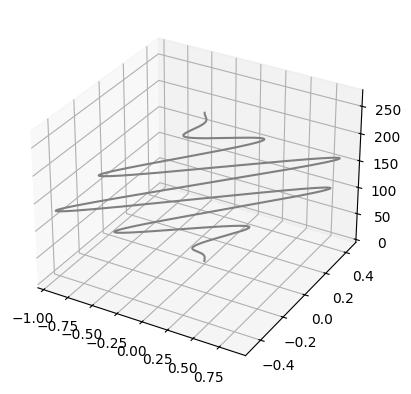

In [10]:
ax = plt.axes(projection='3d')
# ax.scatter3D(Ax_vals, Ay_vals, ts, c=ts, cmap='Greens')
ax.plot3D(Ax_vals, Ay_vals, ts, 'grey')
plt.show()

In [65]:
def compute_values(kx, kys, T_s, w_s, A_0_s, E_0_s, phase_s):
    import numpy as np
    from scipy.integrate import quad 
    
    def phi_0(k: np.array) -> float:
        k_length = np.sqrt(k[0]**2 + k[1]**2 + k[2]**2)
        solution = 2 ** (3/2) / np.pi / (1 + k_length**2)**2
        return solution

    def M_SFA_VG(t_f: float, t_0: float, k: np.array, w_sim: float,
                 A_0: float, E_0: float, phase: float, epsilon: float, T_f: float, 
                 #sin4cos2, sin4sin2, sin2cos, sin2sin
                ) -> float:
        """
        sin4cos2 and sin4sin2 needs to be the integral and type Piecewise 
        """

        i = complex(0, 1)

        k_squared = k[0]**2 + k[1]**2 + k[2]**2

        # I need to make for kx and ky

        test_sin4cos2 = lambda time: np.sin(np.pi * time / T_s)**4 * np.cos(w_s * time + phase_s)**2
        test_sin4sin2 = lambda time: np.sin(np.pi * time / T_s)**4 * np.sin(w_s * time + phase_s)**2
        test_sin2cos = lambda time: np.sin(np.pi * time / T_s)**2 * np.cos(w_s * time + phase_s)
        test_sin2sin = lambda time: np.sin(np.pi * time / T_s)**2 * np.sin(w_s * time + phase_s)

        # kx here first k[0]
        if k[0] != 0:
            i_x = lambda ts: k[0] * np.sin(np.pi * ts / T_f)**2 * np.cos(w_sim * ts + phase) * np.exp(
                (-1) * i * E_0 * ts +
                     # k^2
                i * (k_squared * ts + 
                     # k*A
                     A_0 / np.sqrt(1 + epsilon**2) * (k[0] * quad(test_sin2cos, 0, ts, epsabs=1e-3, 
                                                                  full_output=False)[0] +
                                                      k[1] * epsilon * quad(test_sin2sin, 0, ts, epsabs=1e-3,
                                                                            full_output=False)[0]
                                                     )  
                     # A ** 2
                      + A_0**2 / (1 + epsilon**2) * (quad(test_sin4cos2, 0, ts, epsabs=1e-3, full_output=False)[0] +
                                                  epsilon**2 * quad(test_sin4sin2, 0, ts, epsabs=1e-3,
                                                                    full_output=False)[0]
                                                 )
                    )
            )
            sol_large_x = quad(i_x, t_0, t_f, epsabs=1e-3, full_output=False, complex_func=True)
        else:
            sol_large_x = [0, 0]

        # ky here first k[1]
        if k[1] != 0:
            i_y = lambda ts: k[1] * np.sin(np.pi * ts / T_f)**2 * epsilon * np.sin(w_sim * ts + phase) * np.exp(
                (-1) * i * E_0 * ts +
                     # k^2
                i * (k_squared * ts + 
                     # k*A
                     A_0 / np.sqrt(1 + epsilon**2) * (k[0] * quad(test_sin2cos, 0, ts, epsabs=1e-3, 
                                                                  full_output=False)[0] +
                                                      k[1] * epsilon * quad(test_sin2sin, 0, ts, epsabs=1e-3,
                                                                            full_output=False)[0]
                                                     ) 
                     # A ** 2
                      + A_0**2 / (1 + epsilon**2) * (quad(test_sin4cos2, 0, ts, epsabs=1e-3, full_output=False)[0] +
                                                  epsilon**2 * quad(test_sin4sin2, 0, ts, epsabs=1e-3,
                                                                    full_output=False)[0]
                                                 )
                    )
            )
            sol_large_y = quad(i_y, t_0, t_f, epsabs=1e-3, full_output=False, complex_func=True)
        else:
            sol_large_y = [0, 0]


        full_integral =  A_0 / np.sqrt(1 + epsilon**2) * (sol_large_y[0] + sol_large_x[0])

        M = (-1) * i * phi_0(k) * full_integral

        return M
    
    def dp_dk(M: complex) -> float:
        return M.real**2 + M.imag**2
    
    return [dp_dk(M_SFA_VG(t_f=T_s, t_0=0, k=np.array([kx, ky, 0]), w_sim=w_s, A_0=A_0_s, E_0=E_0_s, 
                       phase=phase_s,
                       epsilon=0.5, T_f=T_s)) for ky in kys]

tic = datetime.datetime.now()
length = 81
start_val = -4.5
end_val = 4.5
kxs = np.linspace(start_val, end_val, length)
kys = np.linspace(start_val, end_val, length)

# Create a pool of worker processes using pathos
pool = ProcessingPool()  

# Create a partial function with fixed arguments except for kx
partial_compute_values = partial(compute_values, kys=kys, T_s=T_s, w_s=w_s, A_0_s=A_0_s, E_0_s=E_0_s, phase_s=phase_s)

# Map the partial function to kxs
results = pool.map(partial_compute_values, kxs)

kx_plot = np.repeat(kxs, length)
ky_plot = np.tile(kys, length)
values_plot = np.concatenate(results)
toc = datetime.datetime.now()
print(f"Finished, Length: {length}, Time: {toc-tic}")

Finished, Length: 81, Time: 2:53:44.111214


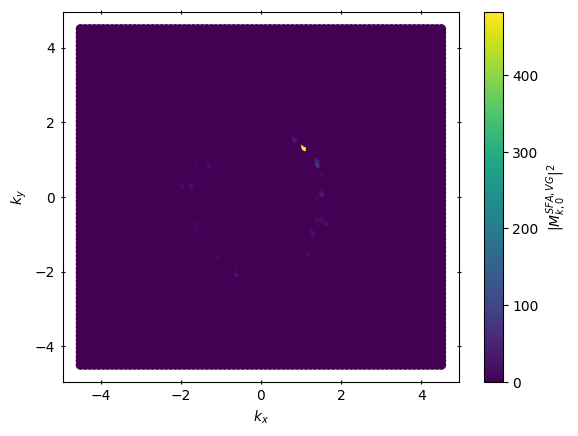

In [66]:
# Lav et farvekodet plot
fig, ax = plt.subplots()
im = ax.scatter(kx_plot, ky_plot, c=values_plot)

# Vend akserne (det er et Kiel diagram), sæt ticks korrekt og titler på
ax.tick_params(direction="inout", right=True, top=True)
ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")

# Indsæt colorbar så man kan se hvad der foregår
fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')


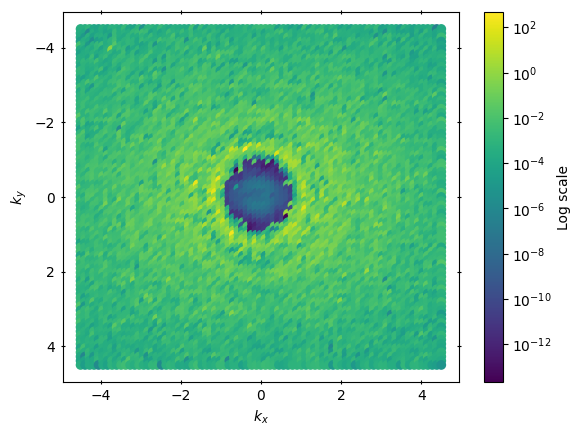

In [55]:
# Create a scatter plot with logarithmic color scale
fig, ax = plt.subplots()
im = ax.scatter(kx_plot, ky_plot, c=values_plot, norm=LogNorm())

# Reverse the y-axis to match a Kiel diagram
ax.invert_yaxis()

# Set labels and ticks
ax.set(xlabel=r"$k_x$", ylabel=r"$k_y$")
ax.tick_params(direction="inout", right=True, top=True)

# Add colorbar with logarithmic scale
cbar = fig.colorbar(im, ax=ax, label=r'$|M^{SFA, VG}_{k, 0}|^2$')
cbar.ax.set_ylabel('Log scale')

plt.show()


In [ ]:
A_0_s

In [67]:
df = pd.DataFrame()
df["kx"] = kx_plot
df["ky"] = ky_plot
df["dpdk"] = values_plot

In [68]:
df

,kx,ky,dpdk
0,-4.5,-4.5000,0.000227
1,-4.5,-4.3875,0.000041
2,-4.5,-4.2750,0.000018
3,-4.5,-4.1625,0.000038
4,-4.5,-4.0500,0.000116
...,...,...,...
6556,4.5,4.0500,0.000469
6557,4.5,4.1625,0.000027
6558,4.5,4.2750,0.000017
6559,4.5,4.3875,0.000151


In [69]:
df.to_pickle("I_er_e14_23:07_12_05.pkl")


In [31]:
dd = pd.read_pickle("A2_is_0_15:06_12_05.pkl")

In [32]:
dd.to_pickle("A2_is_0_15_windows.pkl")

In [29]:
pd.read_pickle("ws_er_2ws_19_windows.pkl")

,kx,ky,dpdk
0,-4.5,-4.5000,0.000398
1,-4.5,-4.3875,0.000296
2,-4.5,-4.2750,0.000181
3,-4.5,-4.1625,0.000030
4,-4.5,-4.0500,0.006121
...,...,...,...
6556,4.5,4.0500,0.000106
6557,4.5,4.1625,0.000680
6558,4.5,4.2750,0.000433
6559,4.5,4.3875,0.000181
